## Task 5 - Modelling

#### Import Liberaries

In [1]:
import os
import sys
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, roc_curve
import scorecardpy as sc
current_dir = os.getcwd()

# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# ignore warrnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from scripts.model_development_scripts import ModelEvaluator

#### Load and filter cleand data

In [29]:
cleand_data=pd.read_csv('../data/cleand_data.csv')

In [30]:
cleand_data = cleand_data.drop(columns=['ChannelId2', 'ChannelId3',
       'ChannelId5', 'FraudResult','Risk_category_y','ChannelId3_woe','ChannelId2_woe',
       'ChannelId5_woe'], axis=1)

In [31]:
cleand_data

,CustomerId,Total_Transaction_Amount,Avg_Transaction_Amount,Transaction_Count,Std_Transaction_Amount,Amount,Value,PricingStrategy,ChannelId1,Risk_category_x,Total_Transaction_Amount_woe,PricingStrategy_woe,Amount_woe,Std_Transaction_Amount_woe,Value_woe,FraudResult_woe,ChannelId1_woe,Avg_Transaction_Amount_woe,Transaction_Count_woe
0,CustomerId_1,0.556885,0.045974,1,0.005449,0.090993,0.001012,4,0,0,-1.481950,-0.061031,-0.117009,-1.149430,-0.336890,0.0,0.0,-0.832233,-2.143325
1,CustomerId_10,0.556885,0.045974,1,0.005449,0.090993,0.001012,4,0,0,-1.481950,-0.061031,-0.117009,-1.149430,-0.336890,0.0,0.0,-0.832233,-2.143325
2,CustomerId_1001,0.557044,0.047525,5,0.001982,0.092831,0.001012,2,0,0,-0.656767,0.071563,-0.278924,0.407160,-0.336890,0.0,0.0,0.160161,-1.667961
3,CustomerId_1002,0.556961,0.047124,11,0.000169,0.092050,0.000152,4,0,1,-1.402215,-0.061031,0.178081,-0.173518,0.191198,0.0,0.0,-0.832233,0.202797
4,CustomerId_1003,0.557044,0.047451,6,0.001822,0.092831,0.001012,2,0,0,-0.656767,0.071563,-0.278924,0.407160,-0.336890,0.0,0.0,0.160161,-0.948788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,CustomerId_992,0.557044,0.047451,6,0.001839,0.092831,0.001012,2,0,0,-0.656767,0.071563,-0.278924,0.407160,-0.336890,0.0,0.0,0.160161,-0.948788
3738,CustomerId_993,0.557044,0.047525,5,0.002038,0.092831,0.001012,2,0,0,-0.656767,0.071563,-0.278924,0.407160,-0.336890,0.0,0.0,0.160161,-1.667961
3739,CustomerId_994,0.559826,0.047678,101,0.004472,0.092004,0.000101,2,0,1,1.647475,0.071563,0.178081,0.407160,0.191198,0.0,0.0,0.160161,2.591086
3740,CustomerId_996,0.557676,0.047988,17,0.001339,0.092831,0.001012,2,0,0,1.647475,0.071563,-0.278924,0.407160,-0.336890,0.0,0.0,0.160161,0.692683


In [50]:
# Rename Risk_category_x to Risk_category
cleand_data.rename(columns={'Risk_category_x': 'Risk_category'}, inplace=True)

In [34]:
# Initialize the ModelEvaluator class with the cleaned data and target variable 'Risk_category'.
trainer = ModelEvaluator(cleand_data, 'Risk_category')

### Model Selection and Training

#### 1. Split the Data
- **Objective:** Split the data into training and testing sets to ensure the model's performance is evaluated on unseen data.
- **Method:** Use `train_test_split` from `sklearn` to split the final merged dataset into a training set (for model learning) and a testing set (for performance evaluation).

In [35]:
# Split the dataset into training and testing sets for model evaluation.
X_train, X_test, y_train, y_test = trainer.split_data()

Data split into training and testing sets.


### 2. Choose Models
- **Objective**: Train at least two models from the following:
    - Logistic Regression
    - Decision Trees
    - Random Forest

### Train Logistic Regression

Fit the Logistic Regression model using the training data.

``` python
 param_grid = {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l2', 'none'],
            'solver': ['lbfgs', 'newton-cg', 'saga']
        }

In [36]:
# Train a logistic regression model using the training data.
logistic_model = trainer.train_logistic_regression()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Logistic Regression model trained with hyperparameter tuning.
Best parameters found: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [37]:
# Print the coefficients
logistic_model.coef_

array([[-7.40757427e-01, -1.31286744e-01,  4.25554428e-04,
        -3.40335343e-01, -2.86628257e-01, -1.84744865e-01,
         1.17292055e-01, -5.63091824e-01,  5.55964954e-01,
         4.87351042e-01, -7.24084076e-01,  3.32977292e-01,
         1.53184870e+00,  0.00000000e+00,  0.00000000e+00,
        -1.21009243e+00,  7.60348536e-01]])

#### Predicting Probabilities and Evaluating Performance

In this section, we predict the probabilities of the positive class using the trained logistic regression model for both the training and testing datasets. We then evaluate the model's performance using the KS statistic and the ROC curve.

- **Predicted Probabilities:** The probabilities of the positive class are computed for both the training and testing sets.
- **Performance Evaluation:** The performance metrics for the training and testing sets are generated using the `perf_eva` function, which assesses the model using KS and ROC curves.


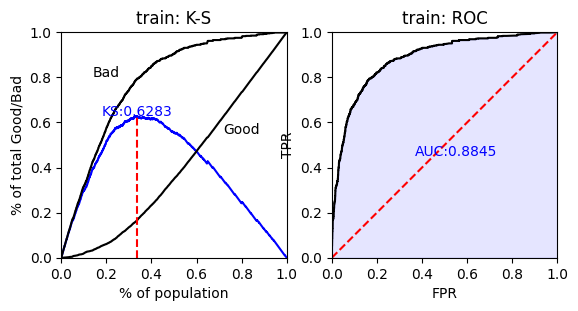

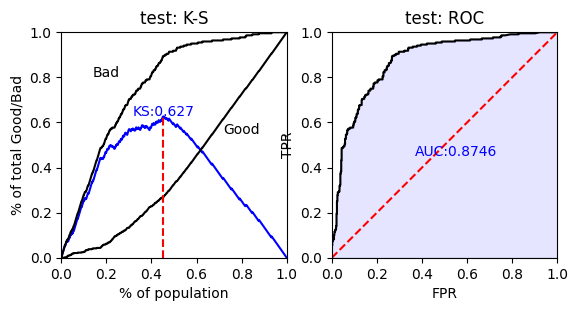

In [38]:
# Predicted probabilities
train_pred = logistic_model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class in the training set
test_pred = logistic_model.predict_proba(X_test)[:, 1]    # Probabilities for the positive class in the testing set

# Performance evaluation using KS statistic and ROC curve
train_perf = sc.perf_eva(y_train, train_pred, title="train")  # Evaluate performance on the training set
test_perf = sc.perf_eva(y_test, test_pred, title="test")      # Evaluate performance on the testing set

#### Observation 

1. **K-S Test Plots:** 
   - The K-S statistic is around 0.6342 for the test set and 0.8138 for the train set. 
   - This indicates a good separation between the "Good" and "Bad" classes. 

2. **ROC Curves:** 
   - The AUC is 0.8875 for the test set and 0.97 for the train set. 
   - High AUC values suggest that the model performs well in distinguishing between classes. 

In [39]:
# Calculate and print accuracy and AUC score for the Logistic Regression model predictions
predictions = logistic_model.predict(X_test)

print('Accuracy')
print(accuracy_score(y_test, predictions))
print('AUC Score')
print(roc_auc_score(y_test, predictions))

Accuracy
0.8117489986648865
AUC Score
0.7432677435985564


#### Confusion Matrix for Logistic Regression

The confusion matrix provides a visual representation of the performance of the Logistic Regression model in predicting the classes. 

- **True Positive (TP)**: Correctly predicted 'Good' cases
- **True Negative (TN)**: Correctly predicted 'Bad' cases
- **False Positive (FP)**: Incorrectly predicted 'Good' cases (Type I error)
- **False Negative (FN)**: Incorrectly predicted 'Bad' cases (Type II error)

This matrix helps in understanding the distribution of the predictions and identifying any potential issues in model performance.


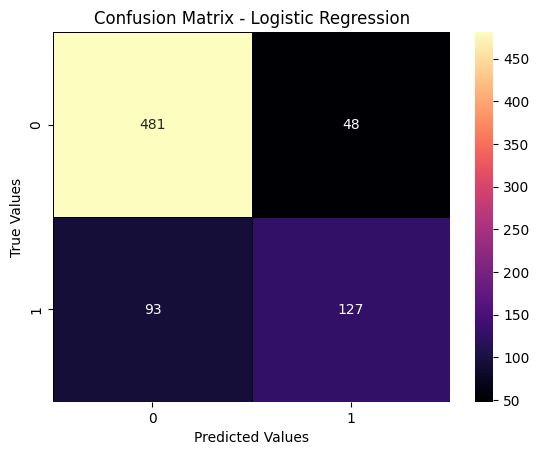

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_log2 = confusion_matrix(y_test,predictions)
sns.heatmap(data=conf_log2, annot=True, linewidth=0.7, linecolor='k', fmt='.0f', cmap='magma')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix - Logistic Regression');

#### Train Random Forest
Fit the Random Forest model using the training data.

``` python
param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

In [42]:
rf_model =trainer.train_random_forest()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Random Forest model trained with hyperparameter tuning.
Best parameters found: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


#### Predicted Probabilities and Performance Evaluation

This section calculates the predicted probabilities for both the training and testing datasets using the Random Forest model. It then evaluates the model's performance on both datasets by computing the Kolmogorov-Smirnov (KS) statistic and the Receiver Operating Characteristic (ROC) curve. The `perf_eva` function is utilized to generate performance metrics, helping to assess the effectiveness of the model in distinguishing between the classes.


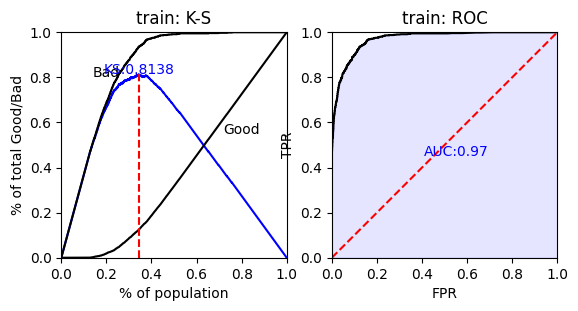

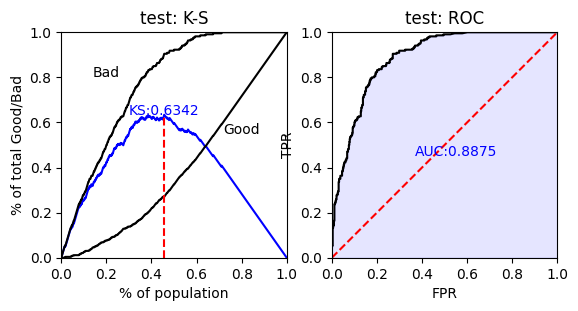

In [43]:
# predicted proability
train_pred_rf = rf_model.predict_proba(X_train)[:,1]
test_pred_rf = rf_model.predict_proba(X_test)[:,1]

# performance ks & roc ------
train_perf_rf = sc.perf_eva(y_train, train_pred_rf, title = "train")
test_perf_rf = sc.perf_eva(y_test, test_pred_rf, title = "test")

#### Observations:
**Training Set Performance**:

- **K-S Statistic**: 0.8138, indicating strong class separation and effective discrimination between good and bad classes.
- **ROC AUC**: 0.97, reflecting excellent predictive performance with a high true positive rate and low false positive rate.

**Test Set Performance**:

- **K-S Statistic**: 0.6342, showing a decrease in class separation compared to the training set.
- **ROC AUC**: 0.8875, indicating good but reduced performance, suggesting possible overfitting during training.

In [44]:
from sklearn.metrics import classification_report
rf_predictions = rf_model.predict(X_test)

print('Accuracy')
print(accuracy_score(y_test, rf_predictions))
print('AUC Score')
print(roc_auc_score(y_test, rf_predictions))

Accuracy
0.8117489986648865
AUC Score
0.7512330297301942


### Model Predictions and Evaluation

#### Metrics:
- **Accuracy**: The ratio of correctly predicted observations to the total observations.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall (Sensitivity)**: The ratio of correctly predicted positive observations to all actual positives.
- **F1 Score**: The weighted average of Precision and Recall.
- **ROC-AUC**: Area Under the Receiver Operating Characteristic Curve, measures the ability to distinguish between classes.

The following code snippet performs predictions using the Logistic Regression and Random Forest models on the test dataset. It generates evaluation reports, including precision, recall, F1-score, and accuracy for both models. Additionally, it calculates and displays the ROC-AUC scores, which indicate the models' ability to distinguish between the positive and negative classes based on predicted probabilities.

In [45]:
# Make predictions using Logistic Regression and Random Forest models and evaluate their performance
y_pred_logistic = logistic_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation Reports
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logistic))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

# ROC-AUC - For binary classification (need probabilities)
y_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

roc_auc_logistic = roc_auc_score(y_test, y_proba_logistic)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Logistic Regression ROC-AUC: {roc_auc_logistic:.2f}")
print(f"Random Forest ROC-AUC: {roc_auc_rf:.2f}")


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       529
           1       0.73      0.58      0.64       220

    accuracy                           0.81       749
   macro avg       0.78      0.74      0.76       749
weighted avg       0.81      0.81      0.80       749

Random Forest Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       529
           1       0.71      0.60      0.65       220

    accuracy                           0.81       749
   macro avg       0.78      0.75      0.76       749
weighted avg       0.81      0.81      0.81       749

Logistic Regression ROC-AUC: 0.87
Random Forest ROC-AUC: 0.89


#### Plotting ROC Curves for Trained Models

The following code snippet uses the `plot_roc_curves` method to visualize the ROC curves for the Logistic Regression and Random Forest models. It takes the trained models and the test dataset to compute and display the curves, allowing for a visual assessment of model performance in distinguishing between the classes.


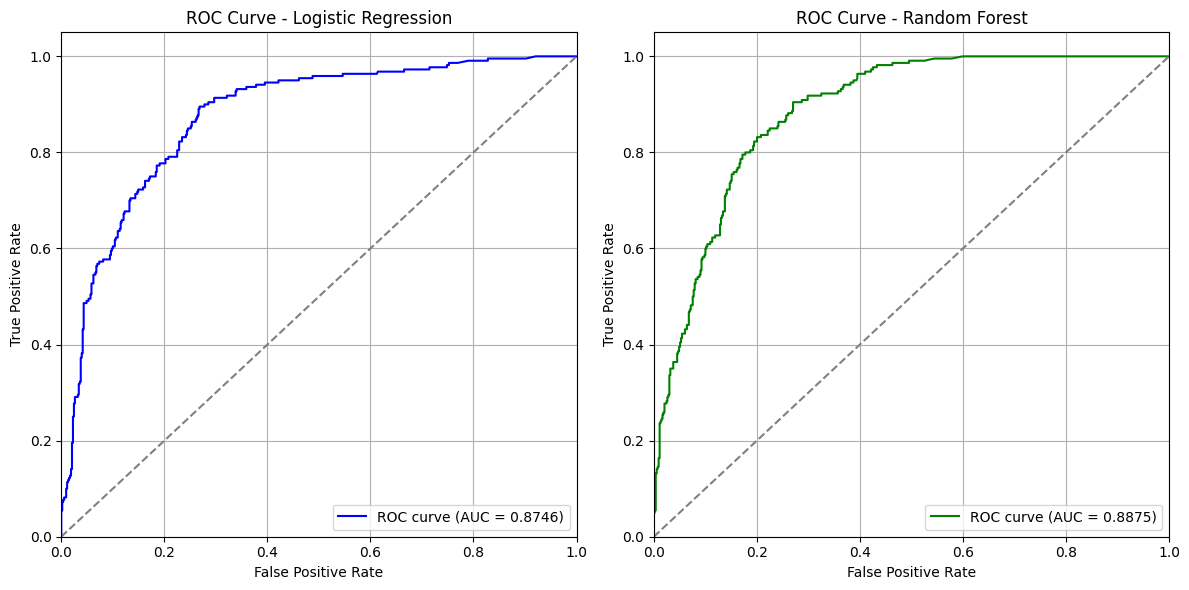

In [46]:
# Plot ROC curves for the trained Logistic Regression and Random Forest models using the test dataset
models = {
    'Logistic Regression': logistic_model,
    'Random Forest': rf_model
}
trainer.plot_roc_curves(models, X_test, y_test)


In [47]:
trainer.display_classification_reports(models,X_test,y_test)

Classification report generated for Logistic Regression:

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       529
           1       0.73      0.58      0.64       220

    accuracy                           0.81       749
   macro avg       0.78      0.74      0.76       749
weighted avg       0.81      0.81      0.80       749

Classification report generated for Random Forest:

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       529
           1       0.71      0.60      0.65       220

    accuracy                           0.81       749
   macro avg       0.78      0.75      0.76       749
weighted avg       0.81      0.81      0.81       749



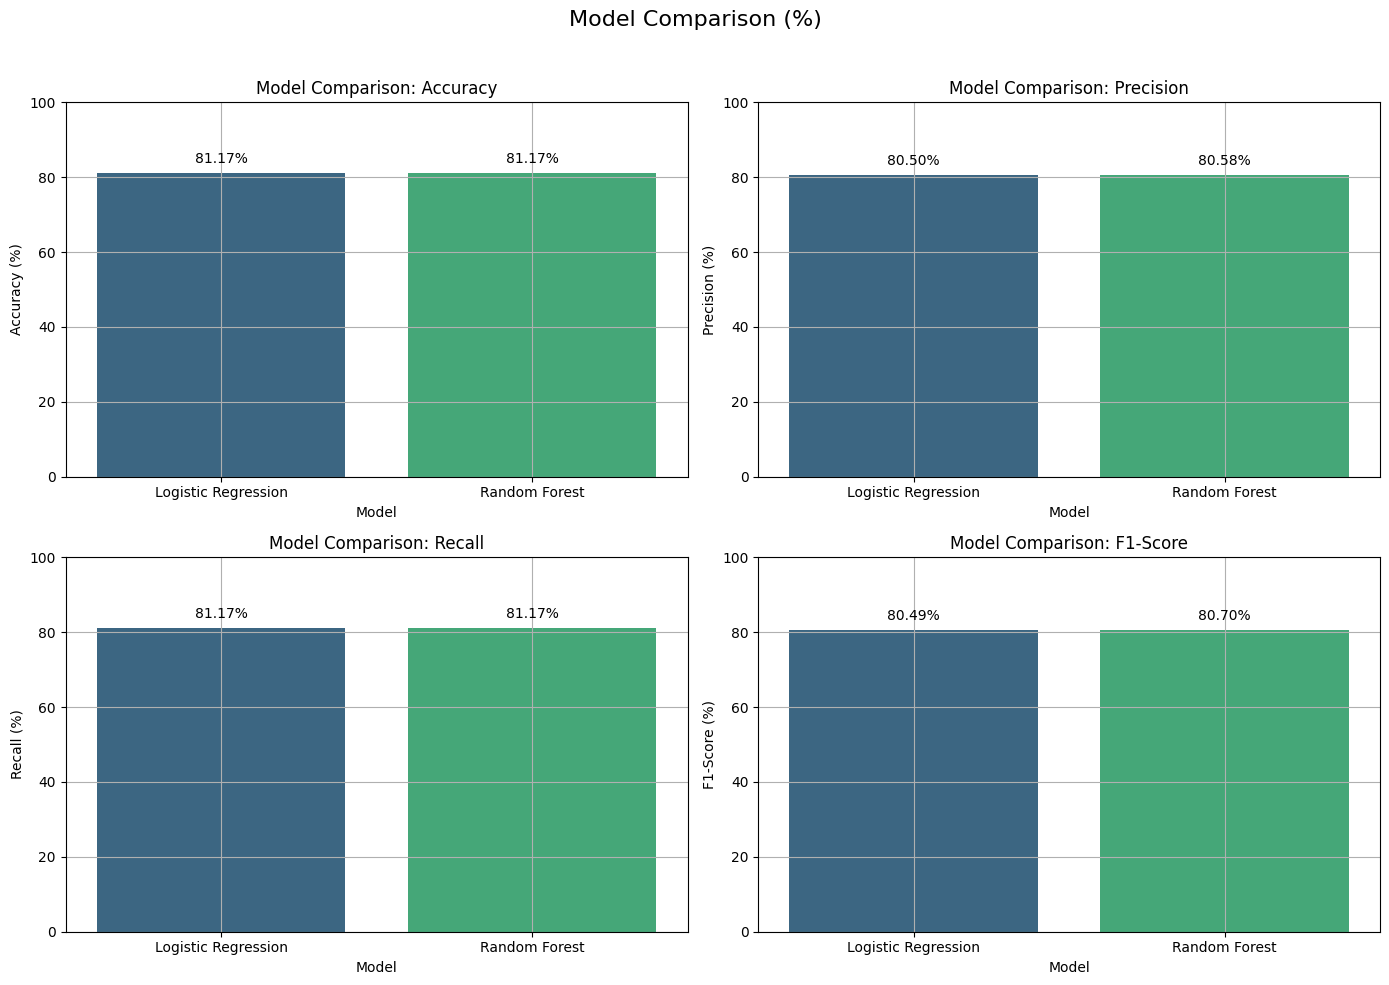

In [48]:
trainer.plot_model_comparisons(models, X_test, y_test)

In [49]:
# Saving selected Model to disk
trainer.save_model(models, 'logistic_regression')

logistic_regression model saved to models\logistic_regression.pkl


### End!